In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import logging
import numpy as np
from scipy.sparse import linalg as spla
import matplotlib.pyplot as plt
import logging
from mpl_toolkits import mplot3d
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import pickle as pkl
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

#add path to data folder
input_folder = "/Volumes/ExtDrive/data"
output_folder = "plots"
dpi=300

first_frame = 1
last_frame = 5000

sphere_list = ['sphere115', 'sphere110', 'sphere118']

f1 = "%s/%s" % (input_folder, sphere_list[0])
f2 = "%s/%s" % (input_folder, sphere_list[1])
f3 = "%s/%s" %(input_folder, sphere_list[2])

fs = [f1, f2, f3]
#om_list = [np.zeros((last_frame-first_frame+1, 512, 256)) for i in range(3)]
#coeffs_list = [np.zeros((last_frame-first_frame+1, 256, 256), dtype=complex) for i in range(3)]
            

In [2]:
#get gammas from Lmid and kappa setting R=1 and tau=1
def get_gammas(Lmid, kappa):
    
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return [gamma0, gamma2, gamma4]

#define function that returns the neutral ell's for a given R/Lambda and kappa
def get_l(Lmid, kappa):
    
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    delta_p = (0.5/gamma4)*(-gamma2+np.sqrt(gamma2**2-4*gamma0*gamma4))
    delta_m = (0.5/gamma4)*(-gamma2-np.sqrt(gamma2**2-4*gamma0*gamma4))
    
    l_p = 0.5*(-1+np.sqrt(17+4*delta_p))
    l_m = 0.5*(-1+np.sqrt(17+4*delta_m))
        
    return l_m, l_p  

#### Load the data and find coefficients and save as a .pkl

In [ ]:
t_arr = np.zeros(last_frame - first_frame + 1)

#create tensor objects 
L_max = 255
S_max = 4
simplesphere = SimpleSphere(L_max, S_max)
omega = TensorField(simplesphere, rank=0)

om_coeffs = np.zeros((last_frame-first_frame+1, 256, 256), dtype=complex)
om = np.zeros((512, 256))

# load omega data
for i, str in enumerate(fs):
    
    for j, ind in enumerate(range(first_frame, last_frame+1, 1)):
        
        with np.load("%s/output_%i.npz" %(fs[i], ind)) as file:
            if ind%100==0: print("Loaded %s/output_%i.npz" %(fs[i], ind))
            
            om = file['om']
            phi = file['phi']
            theta = file['theta']
            t_arr[j] = file['t'][0]
            
        # assign loaded data
        omega.component_fields[0]['g'] = om
        # spectral transform
        omega.forward_phi()
        omega.forward_theta()
        for m in range(len(omega.coeffs)):
            om_coeffs[j, m, m:] = omega.coeffs[m]
            
    save_dict = {'t': t_arr, 'om_coeffs': om_coeffs}
    with open('../data/%s_mod.pkl' %(sphere_list[i]), 'wb') as file:
        pkl.dump(save_dict, file, protocol=pkl.HIGHEST_PROTOCOL)
        
    print('\nSAVED!!!!\n')                        

#### Load pickle data and find the required coeffs and the energy 

In [4]:
L_max = 255
ells = [get_l(2, 1), get_l(4, 1), get_l(8, 1)]
Emodes_list = [None for i in range(3)]
Etotal_list = [None for i in range(3)]
coeffs_list = [None for i in range(3)]

#index of the plots to make 
ind = 1500

for i, str in enumerate(sphere_list):
    print(str)
    with open('../data/%s.pkl' %(sphere_list[i]), 'rb') as file:
        save_dict = pkl.load(file)
        t_arr = save_dict['t']
        om_coeffs = save_dict['om_coeffs']
    
    Emodes = np.zeros_like(t_arr)
    for ell_ in range(int(np.ceil(ells[i][0])), int(np.floor(ells[i][1]))+1, 1):
        Emodes += 0.5*np.abs(om_coeffs[:,0,ell_])**2/(ell_*(ell_+1))
        
    Etotal = np.zeros_like(t_arr)
    for m_ in range(L_max+1):
        for ell_ in range(L_max+1):
            if ell_!=0:
                Etotal += 0.5*(np.abs(om_coeffs[:,m_,ell_])**2)/(ell_*(ell_+1))
    
    Etotal_list[i] = Etotal
    Emodes_list[i] = Emodes 
    coeffs_list[i] = om_coeffs[ind-1, :, :]
                
    

sphere115
sphere110
sphere118


# Figure 2 without $v_\phi$

Loaded /Volumes/ExtDrive/data/sphere115/output_1500.npz
Time is 14.991000
Loaded /Volumes/ExtDrive/data/sphere110/output_1500.npz
Time is 14.991000
Loaded /Volumes/ExtDrive/data/sphere118/output_1500.npz
Time is 14.991000
2019-10-24 11:27:34,847 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-10-24 11:27:34,849 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-10-24 11:28:09,932 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-10-24 11:28:09,935 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-10-24 11:28:38,593 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-10-24 11:28:38,594 matplotlib.texmanager 0/1 INFO :: No La

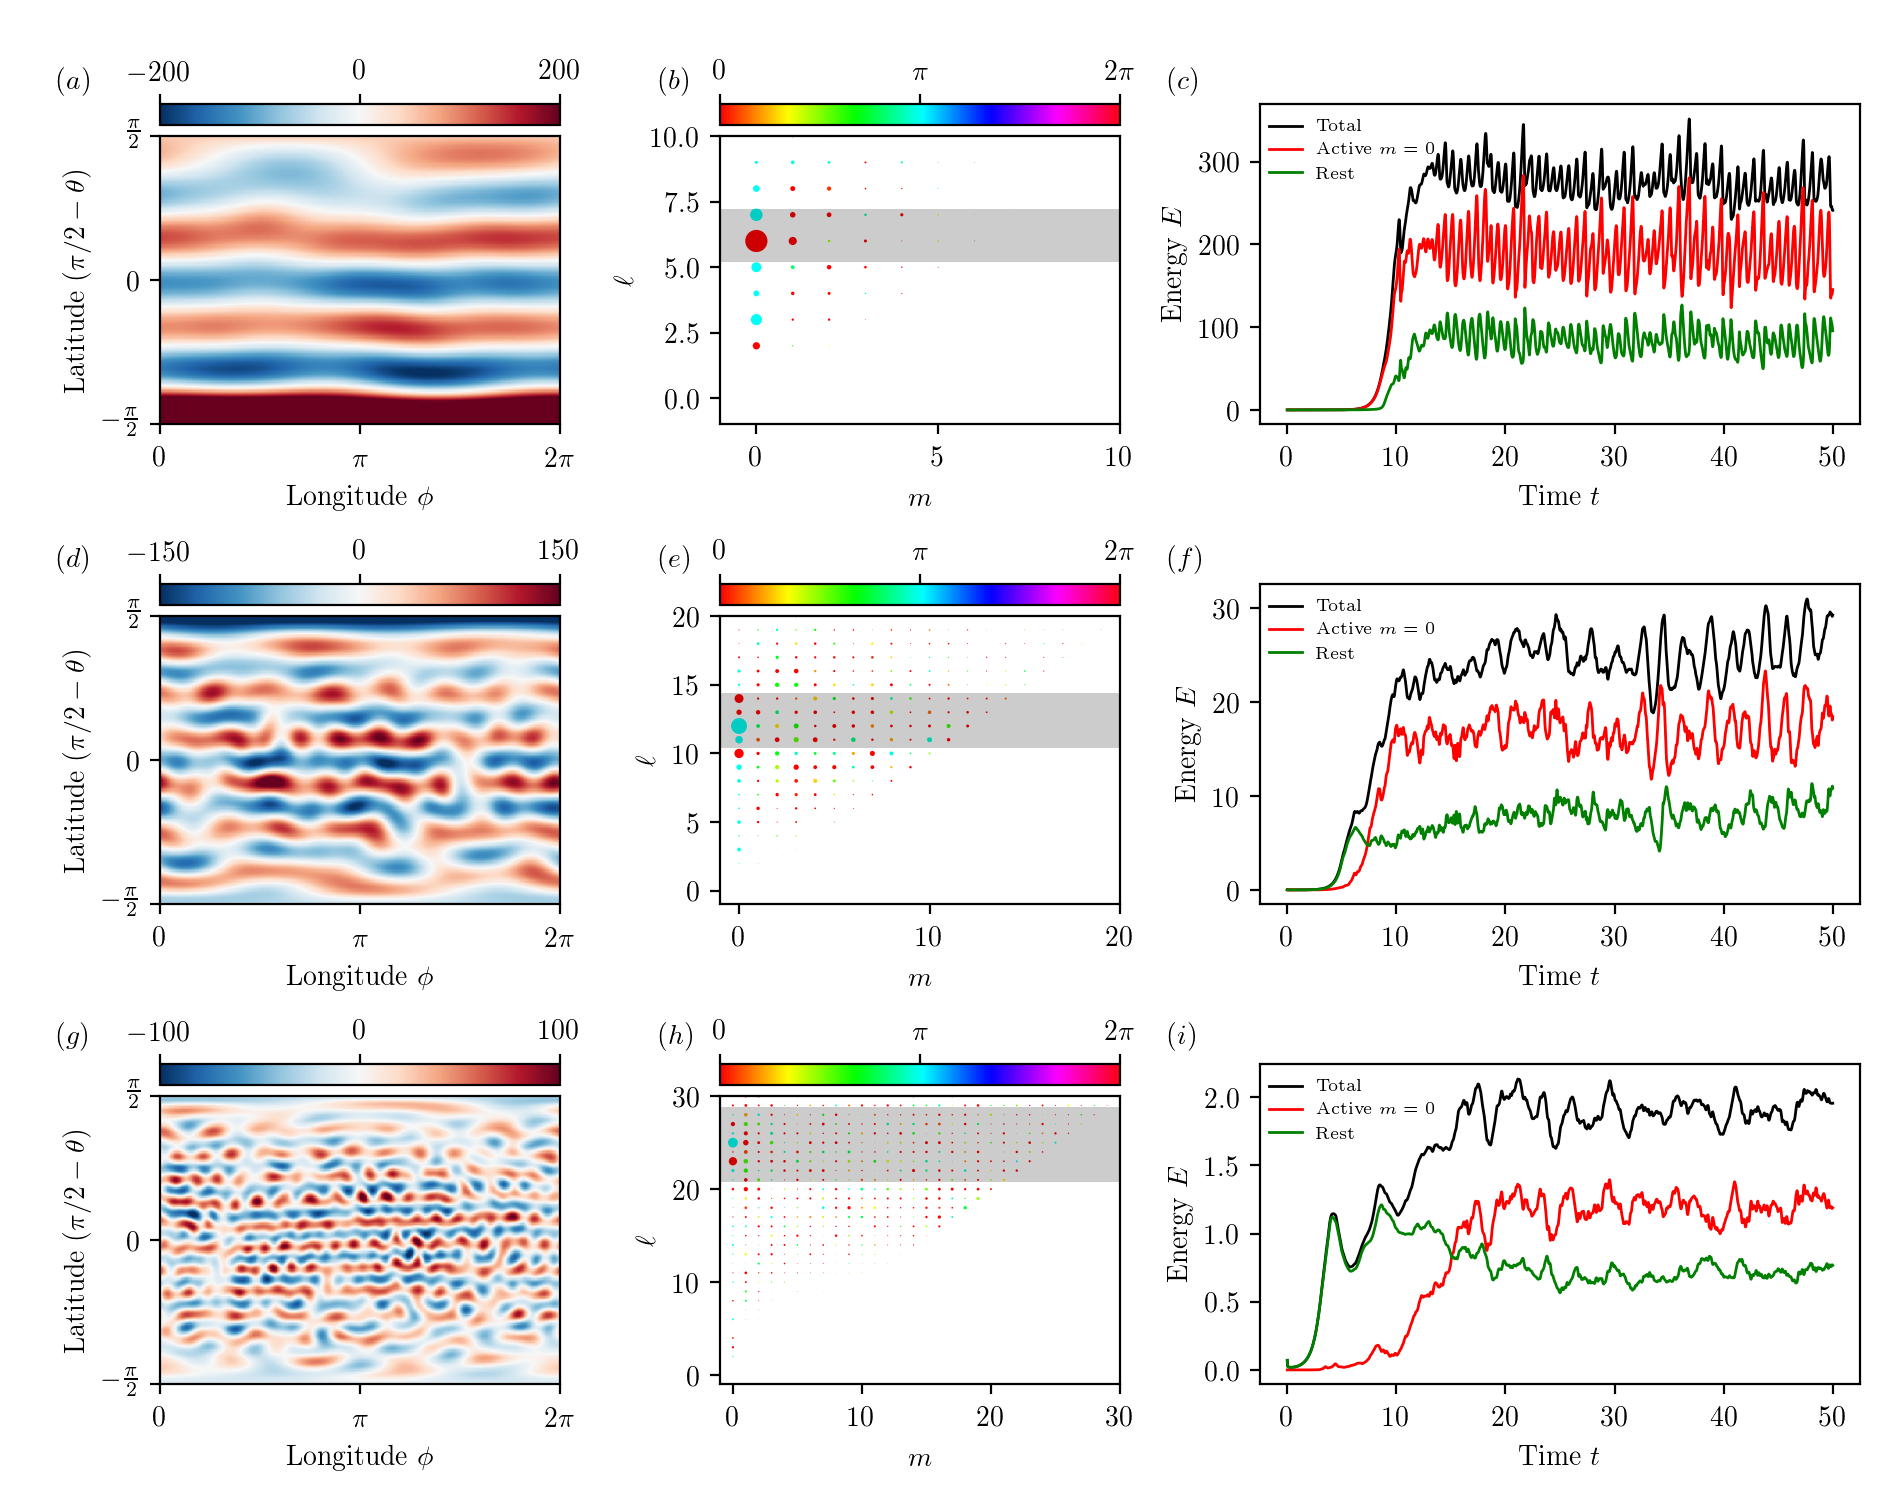

In [28]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6), dpi=200)

#make axes 
axes = [None for i in range(9)]

w1, h1 = 0.2, 0.2
w2, h2 = 0.2, 0.2
w3, h3 = 0.3, 0.2

axes[0] = plt.axes((0.1, 0.7, w1, h1))
axes[3] = plt.axes((0.1, 0.4, w1, h1))
axes[6] = plt.axes((0.1, 0.1, w1, h1))

axes[1] = plt.axes((0.38, 0.7, w2, h2))
axes[4] = plt.axes((0.38, 0.4, w2, h2))
axes[7] = plt.axes((0.38, 0.1, w2, h2))

axes[2] = plt.axes((0.65, 0.7, w3, h3))
axes[5] = plt.axes((0.65, 0.4, w3, h3))
axes[8] = plt.axes((0.65, 0.1, w3, h3))

om_list = [None for i in range(3)]

for i, str in enumerate(fs):
    with np.load("%s/output_%i.npz" %(fs[i], ind)) as file:
        om_list[i] = file['om']
        phi = file['phi']
        theta = file['theta']
        print("Loaded %s/output_%i.npz" %(fs[i], ind))
        print('Time is %f' %(file['t'][0]))
        
clims = [200, 150, 100]
ell_max = [10, 20, 30]
mag_fac = 0.5

for i, str in enumerate(fs):
        
        #color plots 
        #plt.subplot(3,3,3*i+1)
        ax = axes[3*i]
        img = ax.pcolormesh(phi, np.pi/2-theta, om_list[i].T, cmap='RdBu_r', shading='garoud', rasterized=True)
        ax.set_ylabel(r'Latitude $(\pi/2-\theta)$', usetex=True); 
        ax.set_yticks([-np.pi/2, 0, np.pi/2])
        ax.set_yticklabels([r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$'])
        ax.set_xlabel(r'Longitude $\phi$', usetex=True)
        ax.set_xticks([0, np.pi, 2*np.pi])
        ax.set_xticklabels([r'$0$', r'$\pi$', r'$2 \pi$'])
        img.set_clim([-clims[i], clims[i]])

        ax_divider = make_axes_locatable(ax)
        # add an axes above the main axes.
        cax = ax_divider.append_axes("top", size="7%", pad="4%")
        cb = plt.colorbar(img, cax=cax, orientation="horizontal")
        cax.xaxis.set_ticks_position("top")
        cb.set_ticks([-clims[i], 0, clims[i]])
        
        #modes 
        m = np.arange(0,L_max+1); ell = np.arange(0,L_max+1)
        ellell, mm = np.meshgrid(ell, m)
        
        #plt.subplot(3,3,3*i+2)
        ax = axes[3*i+1]
        mag = np.abs(coeffs_list[i])
        phase = np.angle(coeffs_list[i])
        
        img = ax.scatter(mm.flatten(), ellell.flatten(), mag_fac*mag.flatten(), c=phase.flatten(), \
                    cmap='hsv', edgecolor='none')
        rect = Rectangle((-1, ells[i][0]), ell_max[i]+1, ells[i][1]-ells[i][0], facecolor='k', alpha=0.2)
        ax.add_patch(rect)
        
        ax.set_xlim(-1, ell_max[i]), ax.set_ylim(-1, ell_max[i])
        ax.set_xlabel('$m$', usetex=True), ax.set_ylabel('$\ell$', usetex=True)
        #ax[1].set_title('$\hat{\omega}_{\ell, m}$',fontsize=15)
        #ax.set_aspect('equal')
        img.set_clim(0, 2*np.pi)
        ax_divider = make_axes_locatable(ax)
        # add an axes above the main axes.
        cax = ax_divider.append_axes("top", size="7%", pad="4%")
        cb = plt.colorbar(img, cax=cax, orientation="horizontal")
        cb.set_ticks([0, np.pi, 2*np.pi])
        cb.set_ticklabels(['$0$', r'$\pi$', r'$2 \pi$'])
        cax.xaxis.set_ticks_position("top")
    
        #plt.subplot(3,3,3*i+3)
        ax = axes[3*i+2]
        ax.plot(t_arr, Etotal_list[i], 'k', linewidth=1)
        ax.plot(t_arr, Emodes_list[i], 'r', linewidth=1)
        ax.plot(t_arr, Etotal_list[i] - Emodes_list[i], 'g', linewidth=1)
        ax.set_xlabel(r'Time $t$', usetex=True)
        ax.set_ylabel(r'Energy $E$', usetex=True)
        ax.legend(['Total', 'Active $m=0$', 'Rest'], fontsize=6, frameon=False, loc='upper left', \
                  bbox_to_anchor=(-0.01,0.5,0.5,0.5))
        
#add figure markers
#plt.annotate('$(a)$', xy=(0.03, 0.94), xycoords='figure fraction');
#plt.annotate('$(b)$', xy=(0.35, 0.94), xycoords='figure fraction');
#plt.annotate('$(c)$', xy=(0.62, 0.94), xycoords='figure fraction');

#plt.annotate('$(d)$', xy=(0.03, 0.62), xycoords='figure fraction');
#plt.annotate('$(e)$', xy=(0.35, 0.62), xycoords='figure fraction');
#plt.annotate('$(f)$', xy=(0.62, 0.62), xycoords='figure fraction');

#plt.annotate('$(g)$', xy=(0.03, 0.3), xycoords='figure fraction');
#plt.annotate('$(h)$', xy=(0.35, 0.3), xycoords='figure fraction');
#plt.annotate('$(i)$', xy=(0.62, 0.3), xycoords='figure fraction');

        
#plt.tight_layout()
plt.savefig('../plots/fig2_modes.pdf', bbox_inches='tight')

# Figure 2 with $v_\phi$

Loaded /Volumes/ExtDrive/data/sphere115/output_1500.npz
Time is 14.991000
Loaded /Volumes/ExtDrive/data/sphere110/output_1500.npz
Time is 14.991000
Loaded /Volumes/ExtDrive/data/sphere118/output_1500.npz
Time is 14.991000


//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


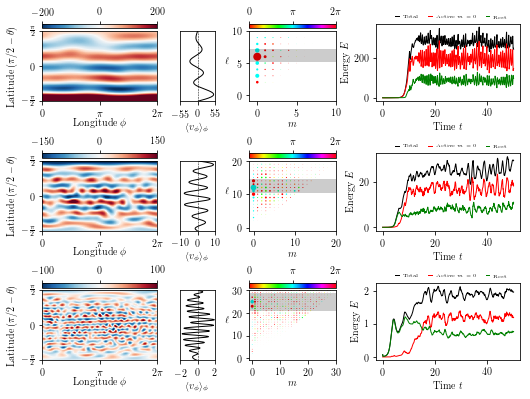

In [9]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size': 10})
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))

#make axes 
axes = [None for i in range(9)]

w1, h1 = 0.3, 0.18
w2, h2 = 0.15, 0.18
w3, h3 = 0.25, 0.18

axes[0] = plt.axes((0.1, 0.7, w1, h1))
axes[3] = plt.axes((0.1, 0.4, w1, h1))
axes[6] = plt.axes((0.1, 0.1, w1, h1))

axes[1] = plt.axes((0.46, 0.7, w2, h2))
axes[4] = plt.axes((0.46, 0.4, w2, h2))
axes[7] = plt.axes((0.46, 0.1, w2, h2))

axes[2] = plt.axes((0.68, 0.7, w3, h3))
axes[5] = plt.axes((0.68, 0.4, w3, h3))
axes[8] = plt.axes((0.68, 0.1, w3, h3))


om_list = [None for i in range(3)]
vph_list = [None for i in range(3)]

for i, str in enumerate(fs):
    with np.load("%s/output_%i.npz" %(fs[i], ind)) as file:
        om_list[i] = file['om']
        vph_list[i] = np.mean(file['v_ph'], axis=0)
        phi = file['phi']
        theta = file['theta']
        print("Loaded %s/output_%i.npz" %(fs[i], ind))
        print('Time is %f' %(file['t'][0]))
        
clims = [200, 150, 100]
vphlims = [55, 10, 2]
ell_max = [10, 20, 30]
mode_ticks = [[0, 5, 10], [0, 10, 20], [0, 10, 20, 30]]
mag_fac = 0.5

for i, str in enumerate(fs):
        
        #color plots 
        #plt.subplot(3,3,3*i+1)
        ax = axes[3*i]
        img = ax.pcolormesh(phi, np.pi/2-theta, om_list[i].T, cmap='RdBu_r', shading='garoud', rasterized=True)
        ax.set_ylabel(r'Latitude $(\pi/2-\theta)$', usetex=True); 
        ax.set_yticks([-np.pi/2, 0, np.pi/2])
        ax.set_yticklabels([r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$'])
        ax.set_xlabel(r'Longitude $\phi$', usetex=True, labelpad=0)
        ax.set_xticks([0, np.pi, 2*np.pi])
        ax.set_xticklabels([r'$0$', r'$\pi$', r'$2 \pi$'])
        img.set_clim([-clims[i], clims[i]])
        
        #add colorbar
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("top", size="7%", pad="4%")
        cb = plt.colorbar(img, cax=cax, orientation="horizontal")
        cax.xaxis.set_ticks_position("top")
        cb.set_ticks([-clims[i], 0, clims[i]])
        
        #add axis for v_ph
        vph_ax = ax_divider.append_axes("right", size="30%", pad="20%")
        vph_ax.plot(vph_list[i], np.pi/2-theta, 'k', linewidth=1, rasterized=True)
        vph_ax.set_yticks([]); vph_ax.set_ylim([-np.pi/2, np.pi/2])
        vph_ax.set_xlim([-vphlims[i], vphlims[i]]);
        vph_ax.set_xticks([-vphlims[i], 0, vphlims[i]]);
        vph_ax.axvline(linestyle='--',color='k',linewidth=0.5)
        vph_ax.set_xlabel(r'$\langle v_\phi\rangle_\phi$')

        #modes 
        m = np.arange(0,L_max+1); ell = np.arange(0,L_max+1)
        ellell, mm = np.meshgrid(ell, m)
        
        #plt.subplot(3,3,3*i+2)
        ax = axes[3*i+1]
        mag = np.abs(coeffs_list[i])
        phase = np.angle(coeffs_list[i])
        
        img = ax.scatter(mm.flatten(), ellell.flatten(), mag_fac*mag.flatten(), c=phase.flatten(), \
                    cmap='hsv', edgecolor='none', rasterized=True)
        rect = Rectangle((-1, ells[i][0]), ell_max[i]+1, ells[i][1]-ells[i][0], facecolor='k', alpha=0.2, rasterized=True)
        ax.add_patch(rect)
        
        ax.set_xlim(-1, ell_max[i]), ax.set_ylim(-1, ell_max[i])
        ax.set_xlabel('$m$', usetex=True, labelpad=0), ax.set_ylabel('$\ell$', usetex=True, rotation=0, labelpad=5)
        img.set_clim(0, 2*np.pi)
        ax.set_xticks(mode_ticks[i]); ax.set_yticks(mode_ticks[i])
        ax_divider = make_axes_locatable(ax)
        # add an axes above the main axes.
        cax = ax_divider.append_axes("top", size="7%", pad="4%")
        cb = plt.colorbar(img, cax=cax, orientation="horizontal")
        cb.set_ticks([0, np.pi, 2*np.pi])
        cb.set_ticklabels(['$0$', r'$\pi$', r'$2 \pi$'])
        cax.xaxis.set_ticks_position("top")
    
        #plt.subplot(3,3,3*i+3)
        ax = axes[3*i+2]
        ax.plot(t_arr, Etotal_list[i], 'k', linewidth=1, rasterized=True)
        ax.plot(t_arr, Emodes_list[i], 'r', linewidth=1, rasterized=True)
        ax.plot(t_arr, Etotal_list[i] - Emodes_list[i], 'g', linewidth=1, rasterized=True)
        ax.set_xlabel(r'Time $t$', usetex=True)
        ax.set_ylabel(r'Energy $E$', usetex=True)
        ax.legend(['Total', 'Active $m=0$', 'Rest'], fontsize=5, frameon=False, loc='lower left', \
                  bbox_to_anchor=(0.1,1,0.5,0.5), handlelength=0.7, ncol=3)
        
#add figure markers
#plt.annotate('$(a)$', xy=(0.03, 0.94), xycoords='figure fraction');
#plt.annotate('$(b)$', xy=(0.35, 0.94), xycoords='figure fraction');
#plt.annotate('$(c)$', xy=(0.62, 0.94), xycoords='figure fraction');

#plt.annotate('$(d)$', xy=(0.03, 0.62), xycoords='figure fraction');
#plt.annotate('$(e)$', xy=(0.35, 0.62), xycoords='figure fraction');
#plt.annotate('$(f)$', xy=(0.62, 0.62), xycoords='figure fraction');

#plt.annotate('$(g)$', xy=(0.03, 0.3), xycoords='figure fraction');
#plt.annotate('$(h)$', xy=(0.35, 0.3), xycoords='figure fraction');
#plt.annotate('$(i)$', xy=(0.62, 0.3), xycoords='figure fraction');

        
#plt.tight_layout()
plt.savefig('../plots/fig2_modes.pdf', bbox_inches='tight', dpi=300)